In [10]:
from dotenv import load_dotenv
import os
import pandas as pd

In [7]:
load_dotenv()


True

In [8]:
API_KEY = os.getenv("FRED_API_KEY")
print(API_KEY[:6] + "..." if API_KEY else "No key found")

e08051...


In [11]:
def fred_series(series_id: str, start="1990-01-01") -> pd.DataFrame:
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    obs = r.json()["observations"]

    df = pd.DataFrame({
        "date": [o["date"] for o in obs],
        series_id: [None if o["value"] == "." else float(o["value"]) for o in obs]
    })
    df["date"] = pd.to_datetime(df["date"])
    return df

In [12]:
dgs2 = fred_series("DGS2")    # 2-Year
dgs10 = fred_series("DGS10")  # 10-Year

yields_df = pd.merge(dgs2, dgs10, on="date", how="inner").sort_values("date")
yields_df.tail()

,date,DGS2,DGS10
9309,2025-09-05,3.51,4.10
9310,2025-09-08,3.49,4.05
9311,2025-09-09,3.54,4.08
9312,2025-09-10,3.54,4.04
9313,2025-09-11,3.52,4.01


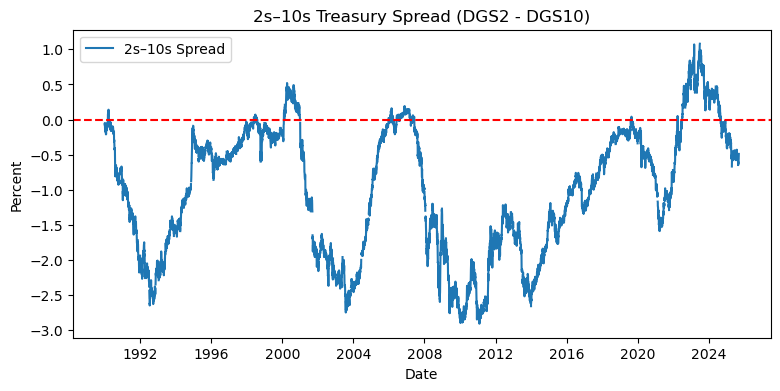

In [14]:
import matplotlib.pyplot as plt

yields_df["spread_2s10s"] = yields_df["DGS2"] - yields_df["DGS10"]

plt.figure(figsize=(9,4))
plt.plot(yields_df["date"], yields_df["spread_2s10s"], label="2s–10s Spread")
plt.axhline(0, linestyle="--", color="red")
plt.title("2s–10s Treasury Spread (DGS2 - DGS10)")
plt.xlabel("Date"); plt.ylabel("Percent")
plt.legend()
plt.show()

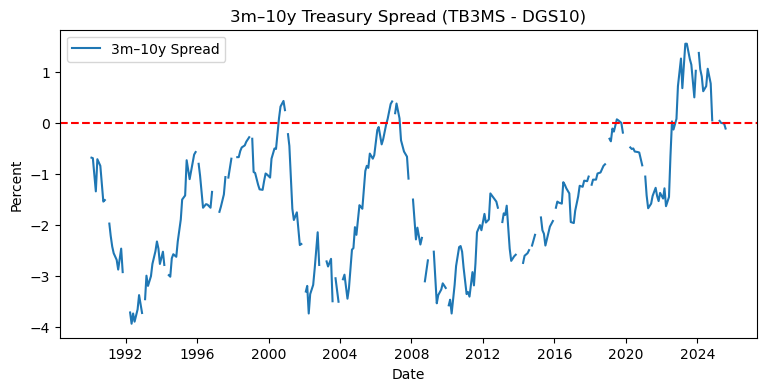

In [15]:
# Pull 3-Month Treasury Bill
tb3m = fred_series("TB3MS")   # 3-Month Treasury Bill

# Merge with the existing 10-Year yield
yields_df2 = pd.merge(tb3m, dgs10, on="date", how="inner").sort_values("date")

# Compute spread
yields_df2["spread_3m10y"] = yields_df2["TB3MS"] - yields_df2["DGS10"]

# Plot
plt.figure(figsize=(9,4))
plt.plot(yields_df2["date"], yields_df2["spread_3m10y"], label="3m–10y Spread")
plt.axhline(0, linestyle="--", color="red")
plt.title("3m–10y Treasury Spread (TB3MS - DGS10)")
plt.xlabel("Date"); plt.ylabel("Percent")
plt.legend()
plt.show()


In [18]:
def fred_series(series_id: str, start="2023-01-01") -> pd.DataFrame:
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    obs = r.json()["observations"]

    df = pd.DataFrame({
        "date": [o["date"] for o in obs],
        series_id: [None if o["value"] == "." else float(o["value"]) for o in obs]
    })
    df["date"] = pd.to_datetime(df["date"])
    return df


In [22]:
maturities = {
    "1M": "DGS1MO", "3M": "DGS3MO", "6M": "DGS6MO", "1Y": "DGS1",
    "2Y": "DGS2", "3Y": "DGS3", "5Y": "DGS5", "7Y": "DGS7",
    "10Y": "DGS10", "20Y": "DGS20", "30Y": "DGS30"
}

# Pick a date
target_date = "2024-01-02"

curve_data = {}
for label, series in maturities.items():
    df = fred_series(series, start=target_date)
    row = df[df["date"] == target_date]
    if not row.empty:
        curve_data[label] = row[series].values[0]

curve_data


{'1M': np.float64(5.55),
 '3M': np.float64(5.46),
 '6M': np.float64(5.24),
 '1Y': np.float64(4.8),
 '2Y': np.float64(4.33),
 '3Y': np.float64(4.09),
 '5Y': np.float64(3.93),
 '7Y': np.float64(3.95),
 '10Y': np.float64(3.95),
 '20Y': np.float64(4.25),
 '30Y': np.float64(4.08)}

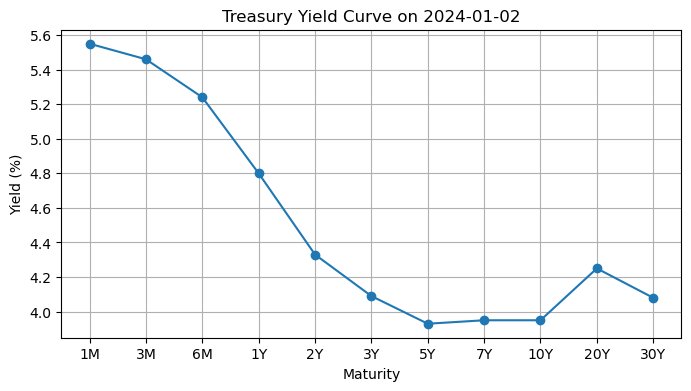

In [23]:
import matplotlib.pyplot as plt

# Convert to ordered lists
labels = list(curve_data.keys())
yields = list(curve_data.values())

plt.figure(figsize=(8,4))
plt.plot(labels, yields, marker="o")
plt.title(f"Treasury Yield Curve on {target_date}")
plt.ylabel("Yield (%)")
plt.xlabel("Maturity")
plt.grid(True)
plt.show()
